# Train Convolutional Autoencoder

This notebook demonstrates the process of training our convolutional autoencoder on our `bollworms-clean` dataset. It can easily be modified to train a new model on a different dataset, and we point out how to do this in the appropriate cell below. OOD detection models based on the embeddings from a pre-trained CAE can be found in other notebooks within this directory.



## Imports

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

## Navigate to `ood-detection` repository

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

# Replace <OOD_DETECTION_REPOSITORY> with the correct location
os.chdir('/content/drive/<OOD_DETECTION_REPOSITORY>')
!git pull

Mounted at /content/drive/
Already up to date.


## Build training and validation datasets

Below we perform an 80/20 train/test split on the images in `ood-detection/data/bollworms-clean-train/ID`. To train this model on a different dataset, simply change the directory inside the call to `find_image_files` below.

In [3]:
from data_utils.datasets import find_image_files, build_dataset
from sklearn.model_selection import train_test_split

# These keyword arguments will be shared by all image datasets
ds_kwargs = {'cache': True, 'image_shape': (256, 256, 3), 'batch_size': 32, 'shuffle_buffer': 512}

# Build training and validation sets of ID images for autoencoder model
train_id_df = find_image_files('data/bollworms-clean-train/ID')
train_id_df, val_id_df = train_test_split(train_id_df, test_size=0.2, random_state=297)
train_id_ds = build_dataset(train_id_df, augment=True, shuffle=True, **ds_kwargs)
val_id_ds = build_dataset(val_id_df, augment=False, shuffle=False, **ds_kwargs)

Found 5800 image files in folder "data/bollworms-clean-train/ID"


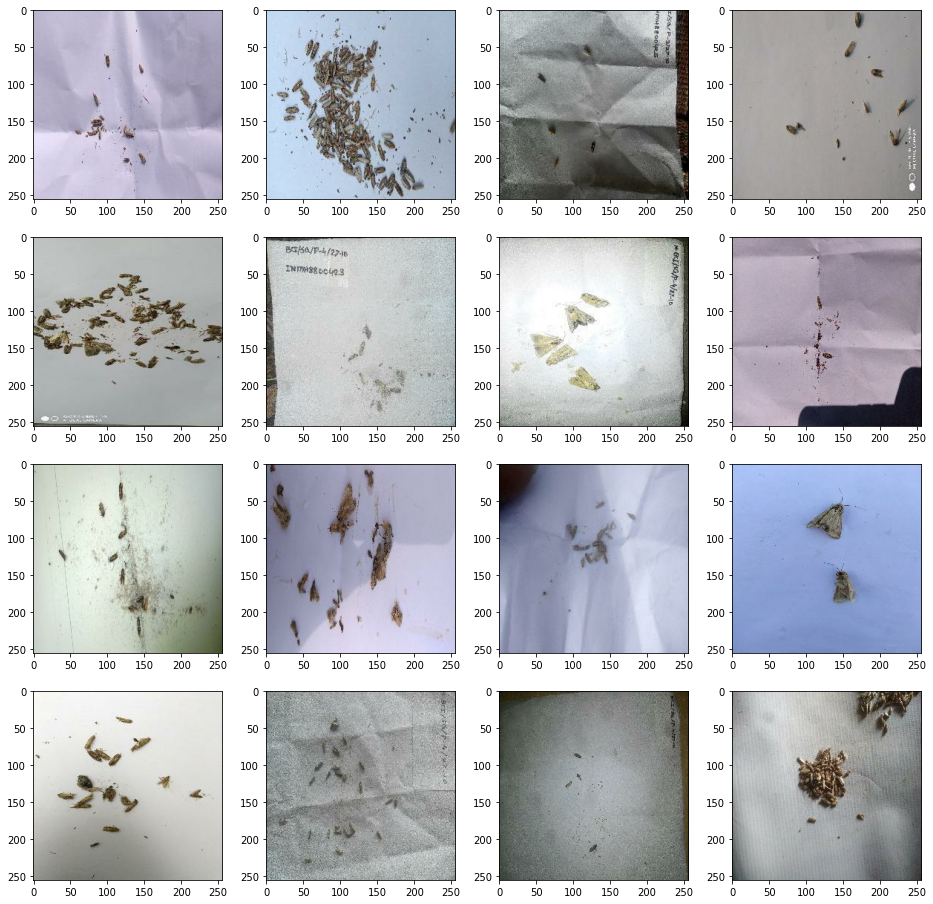

In [5]:
# Display sample images from validation dataset
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for input_images, _ in val_id_ds.take(1):
    for ax, image in zip(axes.flatten(), input_images[:16]):
        ax.imshow(image)

## Train model

As soon as training begins, a new folder is created called `ood-detection/logs/<model_name>`. Loss curves, intermediate results, final results, and model checkpoints will be saved here during the training process. 

In [ ]:
from models.autoencoder import Autoencoder

# Initialize autoencoder model
autoencoder = Autoencoder(name='20221202-Benchmark-ID', # CHANGE NAME BEFORE RUNNING THIS CELL
                          init_filters=32, 
                          filter_mult=2, 
                          filter_mult_every=2, 
                          max_encode_blocks=None,
                          kernel_size=3, 
                          activation=tf.keras.layers.LeakyReLU(alpha=0.2), 
                          batch_norm=True,
                          kernel_regularizer=None,
                          kernel_initializer='he_normal',
                          image_shape=ds_kwargs['image_shape'])

# Build the model weights, compile it, and print a summary
autoencoder.build((None, *ds_kwargs['image_shape']))
autoencoder.compile(loss=tf.keras.losses.MeanSquaredError(), 
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipvalue=2))
autoencoder.summary()

# Train model using the specified method
autoencoder.train(train_id_ds, 
                  val_id_ds, 
                  method='greedy', # ['greedy', 'end_to_end', 'fine_tune']
                  epochs=250, 
                  patience=25, 
                  savefigs=True, 
                  resume_from=None, 
                  verbose=1)

Output hidden; open in https://colab.research.google.com to view.

## Visualize trained model outputs on ID images

The code cell below uses a built-in function in the `Autoencoder` class to display the reshaped latent codes and output images for the first 8 images in the input dataset.

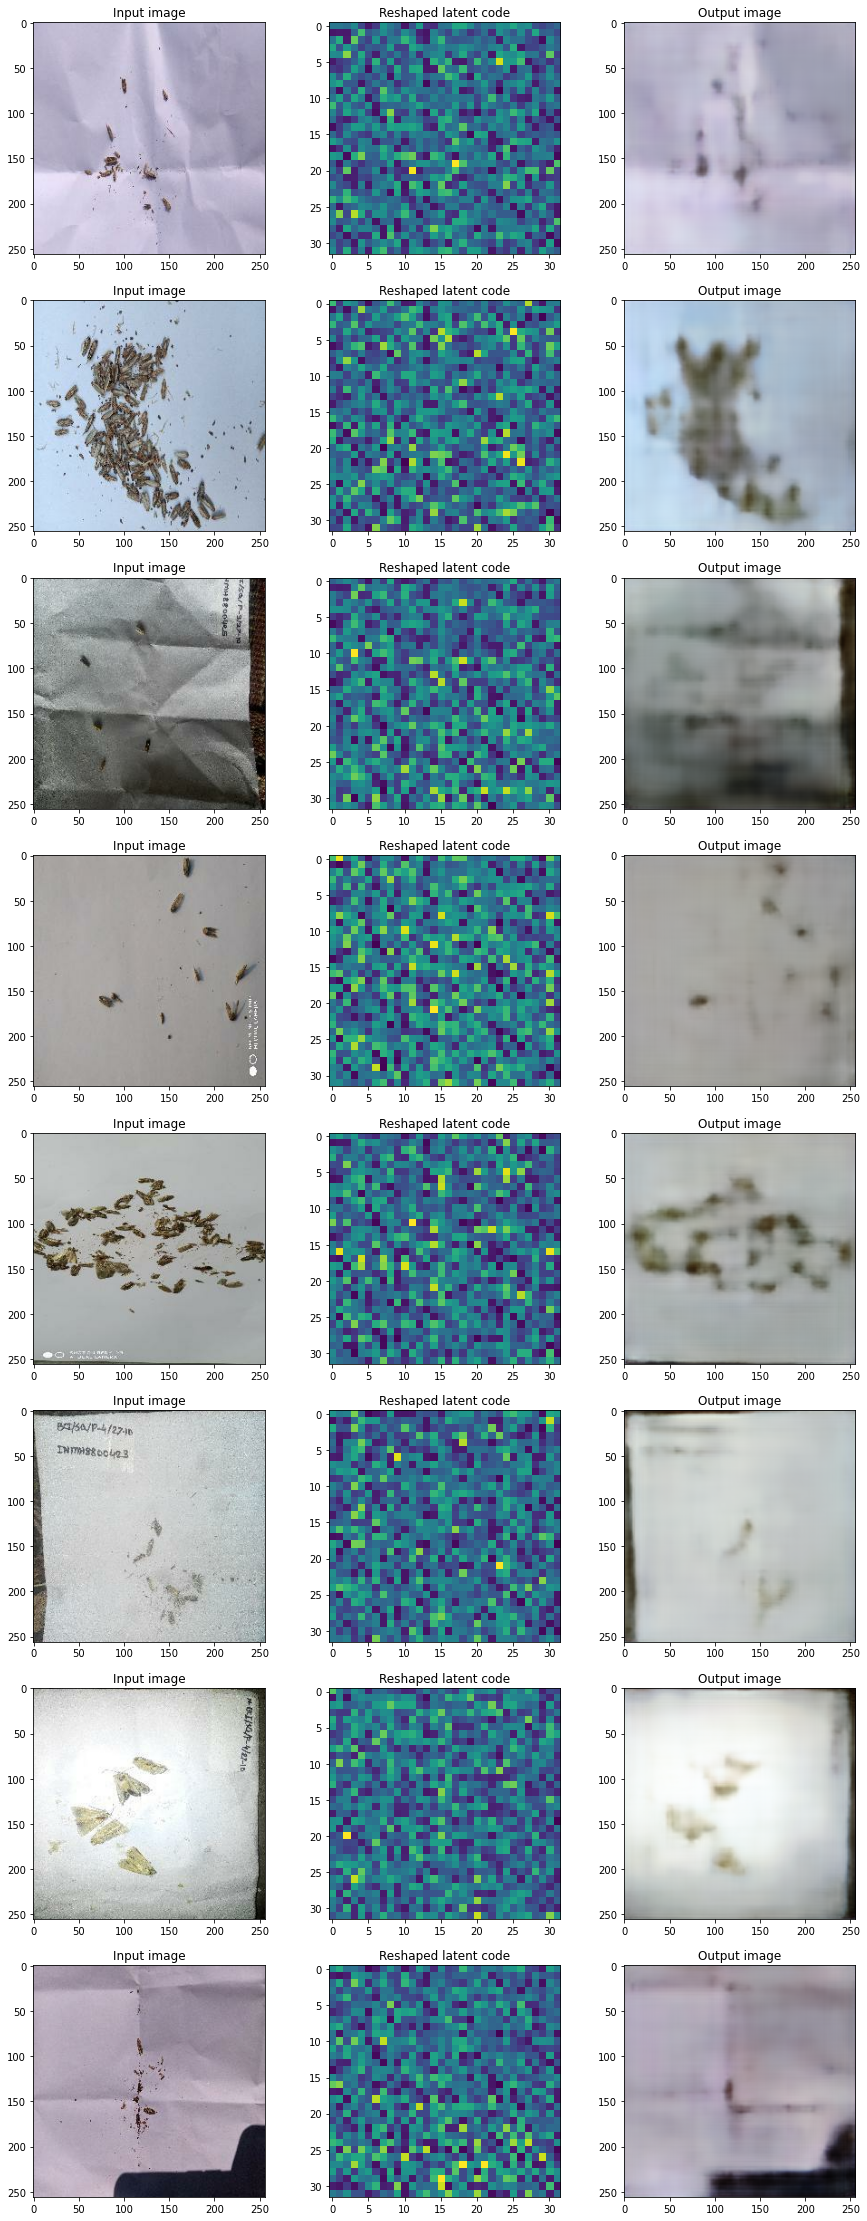

In [ ]:
autoencoder.plot_model_outputs(val_id_ds, layer=-2, saveas=None)

## Visualize trained model outputs on OOD images

We didn't use any OOD images to train the model, but let's load some of these images here so we can see what they look like when we pass them through the model. The `layer` parameter below selects the layer of the `autoencoder`; the latent dimension starts off big in the first layer and gets smaller the layer increases. You can specify the model layer usings positive or negative indices, like a regular python `list`.

In [7]:
# Build training set of OOD images
train_ood_df = find_image_files('data/bollworms-clean-train/OOD')
train_ood_ds = build_dataset(train_ood_df, augment=False, shuffle=False, **ds_kwargs)

Found 975 image files in folder "data/bollworms-clean-train/OOD"


In [ ]:
autoencoder.plot_model_outputs(train_ood_ds, layer=-2, saveas=None)

Output hidden; open in https://colab.research.google.com to view.

## Visualize trained model performance

The `Autoencoder` class has several built-in plotting routines for visualizing trained model performance. Each takes in `ds_dict` object that is a dictionary whose key-value pairs are the names you want to give each dataset and the datasets themselves. First we construct this dictionary using all three datasets that we loaded above, then we pass it to the `plot_loss` and `plot_ssim` methods of the `Autoencoder` class. We set `savefigs=True` to save these figures in `ood-detection/logs/<model_name>`. A matching `loss_dict` and `ssim_dict` is returned by these routines so these values can be used for further analysis.

In [ ]:
train_ds_dict = {'Train ID': train_id_ds, 'Val ID': val_id_ds, 'Train OOD': train_ood_ds}

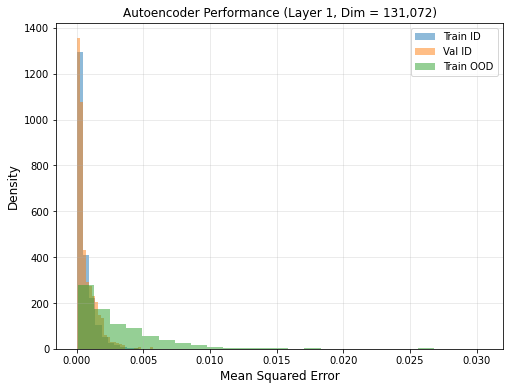

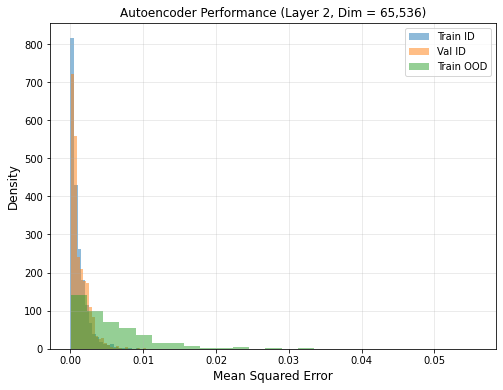

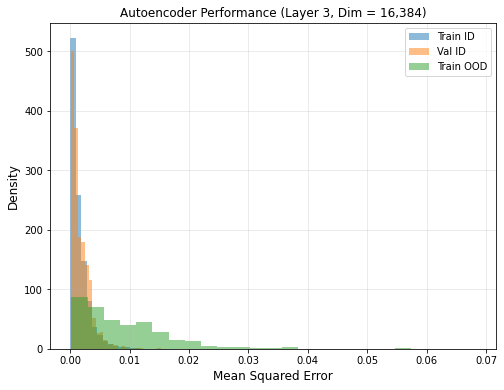

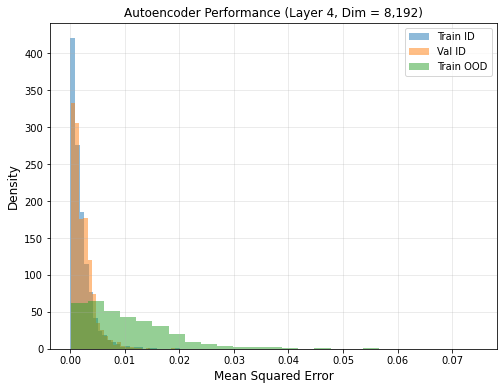

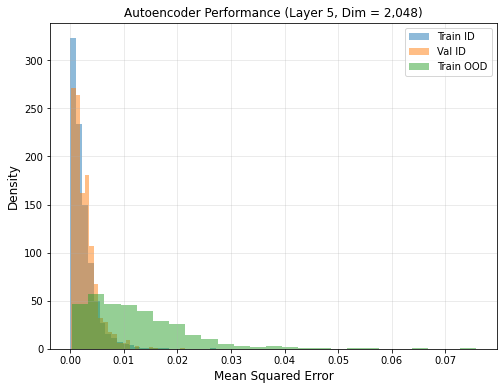

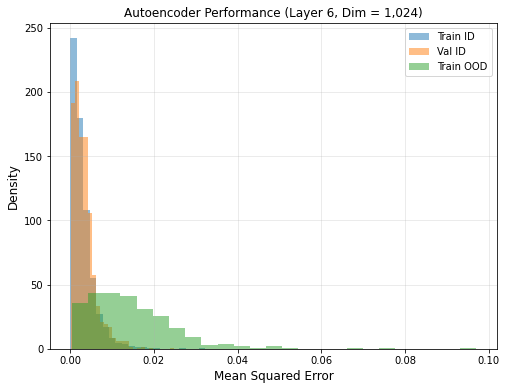

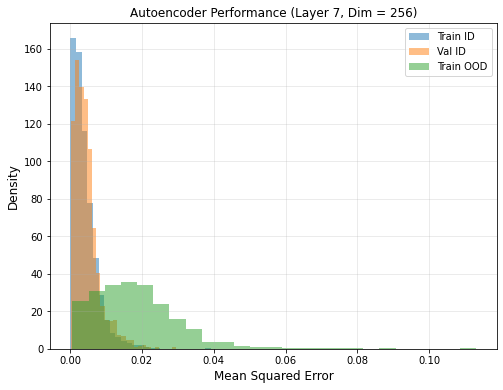

In [ ]:
# Plot loss for all datasets in this ds_dict at each of the specified layers
train_loss_dicts = autoencoder.plot_loss(train_ds_dict, layers=range(1, autoencoder.encode_blocks), savefigs=True)

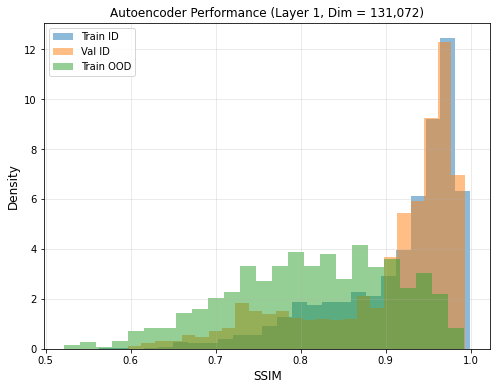

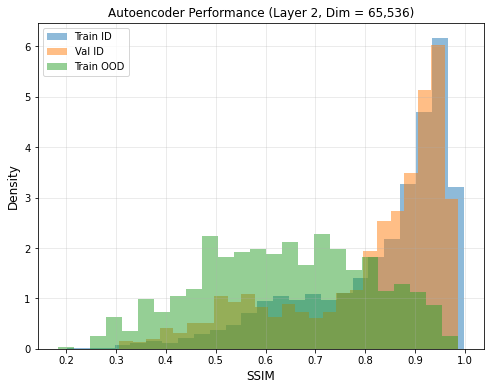

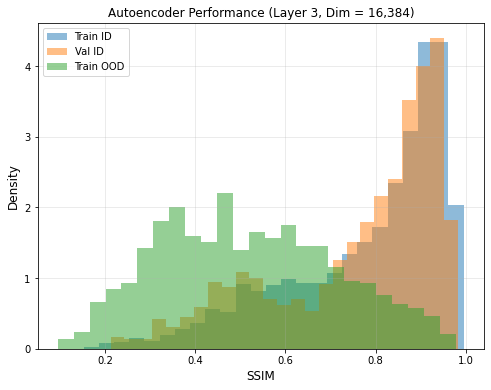

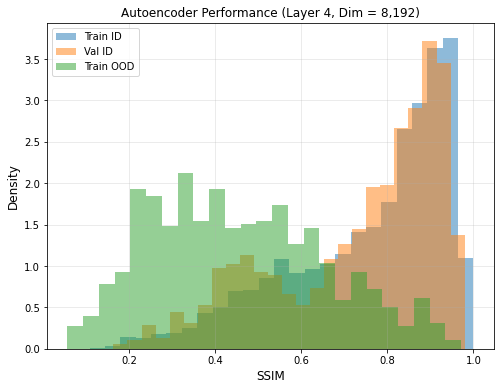

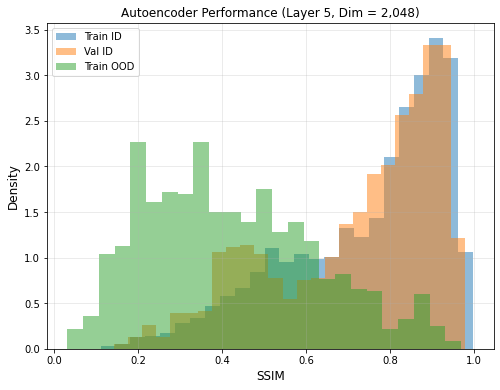

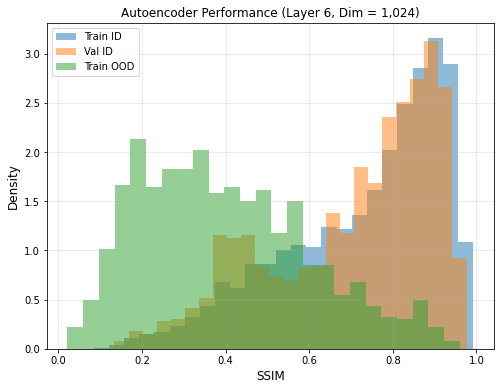

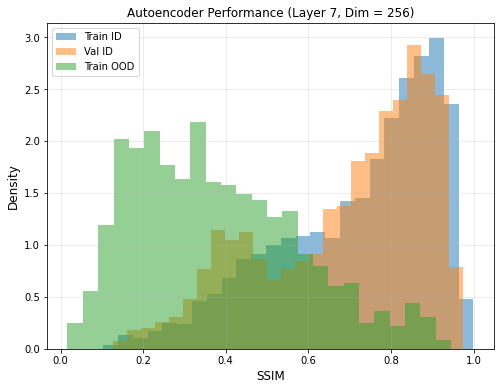

In [ ]:
# Plot SSIM for all datasets in this ds_dict at each of the specified layers
train_ssim_dicts = autoencoder.plot_ssim(train_ds_dict, layers=range(1, autoencoder.encode_blocks), savefigs=True)

## Compute latent codes

We can also use our `ds_dict` object and the `get_latent_codes_at_layer` method of the `Autoencoder` class to obtain a `latent_dicts` object that will give us all of the latent codes for each of the datasets in `ds_dict` at every layer in the model. As above, we start extracting latent codes at layer 1, because the size of the latent codes in layer 0 is larger than the input images themselves, so layer 1 is the first layer that represents true image compression.

In [ ]:
train_latent_dicts = dict()
for layer in range(1, autoencoder.encode_blocks):
    train_latent_dicts[layer] = {label: autoencoder.get_latent_codes_at_layer(ds, layer) for label, ds in train_ds_dict.items()}

train_latent_dicts[1] = { "Train ID": (6223, 64, 64, 32), "Val ID": (1556, 64, 64, 32), "Train OOD": (975, 64, 64, 32) }
train_latent_dicts[2] = { "Train ID": (6223, 32, 32, 64), "Val ID": (1556, 32, 32, 64), "Train OOD": (975, 32, 32, 64) }
train_latent_dicts[3] = { "Train ID": (6223, 16, 16, 64), "Val ID": (1556, 16, 16, 64), "Train OOD": (975, 16, 16, 64) }
train_latent_dicts[4] = { "Train ID": (6223, 8, 8, 128), "Val ID": (1556, 8, 8, 128), "Train OOD": (975, 8, 8, 128) }
train_latent_dicts[5] = { "Train ID": (6223, 4, 4, 128), "Val ID": (1556, 4, 4, 128), "Train OOD": (975, 4, 4, 128) }
train_latent_dicts[6] = { "Train ID": (6223, 2, 2, 256), "Val ID": (1556, 2, 2, 256), "Train OOD": (975, 2, 2, 256) }
train_latent_dicts[7] = { "Train ID": (6223, 1, 1, 256), "Val ID": (1556, 1, 1, 256), "Train OOD": (975, 1, 1, 256) }
